<a href="https://colab.research.google.com/github/vansigure/tutorial/blob/main/docs/demo_ML%2BSHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoGluon Tabular - Quick Start

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/stable/docs/tutorials/tabular/tabular-quick-start.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/stable/docs/tutorials/tabular/tabular-quick-start.ipynb)

In this tutorial, we will see how to use AutoGluon's `TabularPredictor` to predict the values of a target column based on the other columns in a tabular dataset.

Begin by making sure AutoGluon is installed, and then import AutoGluon's `TabularDataset` and `TabularPredictor`. We will use the former to load data and the latter to train models and make predictions.

In [ ]:
!python -m pip install --upgrade pip
!python -m pip install autogluon

In [3]:
from autogluon.tabular import TabularPredictor
import pandas as pd
import sklearn
import shap

## Example Data

This example uses a processed version of the [adult census income dataset](https://archive.ics.uci.edu/ml/datasets/Adult) from the UCI machine learning data repository, which is a binary classification task. The goal is to predict the ture or false of **lable** variable based on other features.

In [4]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

In [5]:
label = 'label'
feature_names = X_train.columns
train_data = X_train.copy()
train_data[label] = y_train
test_data = X_valid.copy()
test_data[label] = y_valid

train_data = train_data.sample(500)
test_data = test_data.sample(500)
display(train_data.head())

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
32136,37.0,4,14.0,4,10,0,4,0,0.0,0.0,40.0,39,False
31727,50.0,4,14.0,2,4,4,4,1,0.0,0.0,50.0,39,True
31889,38.0,4,12.0,2,3,4,4,1,0.0,0.0,45.0,39,False
10715,70.0,0,9.0,6,0,1,4,0,0.0,0.0,4.0,39,False
27248,26.0,4,9.0,2,7,4,4,1,0.0,0.0,45.0,39,False


In [6]:
train_data["label"] = train_data["label"].astype(int)
test_data["label"] = test_data["label"].astype(int)
train_data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
32136,37.0,4,14.0,4,10,0,4,0,0.0,0.0,40.0,39,0
31727,50.0,4,14.0,2,4,4,4,1,0.0,0.0,50.0,39,1
31889,38.0,4,12.0,2,3,4,4,1,0.0,0.0,45.0,39,0
10715,70.0,0,9.0,6,0,1,4,0,0.0,0.0,4.0,39,0
27248,26.0,4,9.0,2,7,4,4,1,0.0,0.0,45.0,39,0


Our targets are stored in the "**label**" column. We convert the boolean *True*/*False* values to 1/0 for convenience.


In [7]:
label = 'label'
train_data[label].describe()

,label
count,500.000000
mean,0.248000
std,0.432284
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Training

We now construct a `TabularPredictor` by specifying the label column name and then train on the dataset with `TabularPredictor.fit()`. We don't need to specify any other parameters. AutoGluon will recognize this is a multi-class classification task, perform automatic feature engineering, train multiple models, and then ensemble the models to create the final predictor.

In [8]:
# optional presets in fit()
time_limit = 60  # for quick demonstration only, you should set this to longest time you are willing to wait (in seconds)
metric = 'roc_auc'  # specify your evaluation metric here
presets = 'best_quality' # model quality presets. levels including "medium_quality" "good_quality" "high_quality" "best_quality"

predictor = TabularPredictor(label=label).fit(train_data, presets = "good_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20241216_134118"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       11.13 GB / 12.67 GB (87.8%)
Disk Space Avail:   74.18 GB / 107.72 GB (68.9%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions 

Model fitting should take a few minutes or less depending on your CPU. You can make training faster by specifying the `time_limit` argument. For example, `fit(..., time_limit=60)` will stop training after 60 seconds. Higher time limits will generally result in better prediction performance, and excessively low time limits will prevent AutoGluon from training and ensembling a reasonable set of models.

You can also choose different fitting qualities with the `presets` argument in `fit`. The default is set to "medium quality" for quick demostration (check [Preset](https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets) for more details). You should use high or best quality in formal usage.



## Prediction

Once we have a predictor that is fit on the training dataset, we can load a separate set of data to use for prediction and evaulation.

In [9]:
test_data

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
22779,27.0,4,9.0,4,1,0,0,0,0.0,0.0,8.0,39,0
18358,72.0,0,10.0,3,0,0,4,1,0.0,0.0,3.0,39,0
10295,17.0,4,7.0,4,8,3,4,0,0.0,0.0,7.0,39,0
18659,29.0,1,13.0,4,10,0,2,1,0.0,0.0,40.0,39,0
7476,41.0,4,8.0,2,6,4,4,1,0.0,0.0,40.0,39,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,35.0,4,12.0,0,4,0,4,0,0.0,0.0,50.0,39,0
27584,27.0,4,7.0,5,5,2,4,1,0.0,0.0,40.0,33,0
17597,47.0,4,13.0,2,12,4,4,1,0.0,0.0,60.0,39,1
26588,21.0,4,10.0,4,1,0,3,0,0.0,0.0,40.0,39,0


In [10]:
y_pred = predictor.predict(test_data.drop(columns=[label]))
y_pred.head()

,label
22779,0
18358,0
10295,0
18659,0
7476,0


## Evaluation

We can evaluate the predictor on the test dataset using the `evaluate()` function, which measures how well our predictor performs on data that was not used for fitting the models.

In [11]:
predictor.evaluate(test_data, silent=True)

{'accuracy': 0.844,
 'balanced_accuracy': 0.6872785381782811,
 'mcc': 0.48979574227459144,
 'roc_auc': 0.8785289145186319,
 'f1': 0.5357142857142857,
 'precision': 0.7894736842105263,
 'recall': 0.40540540540540543}

AutoGluon's `TabularPredictor` also provides the `leaderboard()` function, which allows us to evaluate the performance of each individual trained model on the test data.

Check on the *score_val* of the *eval_metric*, the best  model is listed at the top.

In [12]:
predictor.leaderboard(test_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesGini,0.856,0.85,accuracy,0.114337,0.077369,1.202623,0.114337,0.077369,1.202623,1,True,8
1,LightGBMXT,0.844,0.85,accuracy,0.003237,0.001350,2.084433,0.003237,0.001350,2.084433,1,True,3
2,CatBoost,0.844,0.84,accuracy,0.005690,0.001871,1.321350,0.005690,0.001871,1.321350,1,True,7
3,WeightedEnsemble_L2,0.844,0.85,accuracy,0.006653,0.002367,2.194165,0.003417,0.001017,0.109733,2,True,14
4,ExtraTreesEntr,0.844,0.84,accuracy,0.114264,0.088070,0.873195,0.114264,0.088070,0.873195,1,True,9
5,LightGBM,0.838,0.84,accuracy,0.010947,0.002507,0.415346,0.010947,0.002507,0.415346,1,True,4
6,XGBoost,0.834,0.84,accuracy,0.017835,0.004853,0.275871,0.017835,0.004853,0.275871,1,True,11
7,RandomForestGini,0.834,0.83,accuracy,0.102486,0.067321,0.976247,0.102486,0.067321,0.976247,1,True,5
8,RandomForestEntr,0.834,0.83,accuracy,0.116699,0.068000,1.341094,0.116699,0.068000,1.341094,1,True,6
9,LightGBMLarge,0.818,0.83,accuracy,0.055348,0.008162,1.249516,0.055348,0.008162,1.249516,1,True,13


You can also check on the feature importance to find out the contributions of each featur with `feature_importance`. **Note** this way is different from computing the Shapley/SHAP value.

In [13]:
predictor.feature_importance(train_data)

Computing feature importance via permutation shuffling for 12 features using 500 rows with 5 shuffle sets...
	0.78s	= Expected runtime (0.16s per shuffle set)
	0.2s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Education-Num,0.0468,0.006261,0.000038,5,0.059691,0.033909
Relationship,0.0372,0.004382,0.000023,5,0.046222,0.028178
Occupation,0.0284,0.008649,0.000916,5,0.046208,0.010592
Marital Status,0.0268,0.004147,0.000067,5,0.035339,0.018261
Age,0.0240,0.006164,0.000479,5,0.036693,0.011307
Sex,0.0124,0.004775,0.002188,5,0.022232,0.002568
Capital Gain,0.0120,0.001414,0.000023,5,0.014912,0.009088
Hours per week,0.0076,0.003286,0.003323,5,0.014367,0.000833
Workclass,0.0032,0.003633,0.060122,5,0.010681,-0.004281
Country,0.0012,0.001095,0.035242,5,0.003456,-0.001056


## Explaination

With the models well-trained to predict our data (let's assume it has a relatively good performance), we can now use `shap` to explain the contributions of each feature.

In [14]:
import shap

First, we extract the **best model** from our predictor consisted of 13 models.

`model_best` returns the model that AutoGluon **thinks** is most accurate, which is usually an ensemble of many individual models.

In [15]:
best_model = predictor.model_best
model = predictor._trainer.load_model(best_model)
best_model

'WeightedEnsemble_L2'

The best model given by AutoGluon is not the best according to the leaderborad. We can load the particular best model with the highest *score_test*.

In [19]:
i = 7  # index of model in training order
best_model = predictor.model_names()[i]
model = predictor._trainer.load_model(best_model)
best_model

'ExtraTreesGini'

We can now compute SHAP value with the model specified.

In [20]:
explainer = shap.Explainer(model.predict_proba, train_data)
shap_values = explainer(train_data)

PermutationExplainer explainer: 501it [16:49,  2.02s/it]


The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model’s output. Each instance the given explanation is represented by a single dot on each feature row.

use `shap.summary_plot` to get the global contributions of different features.

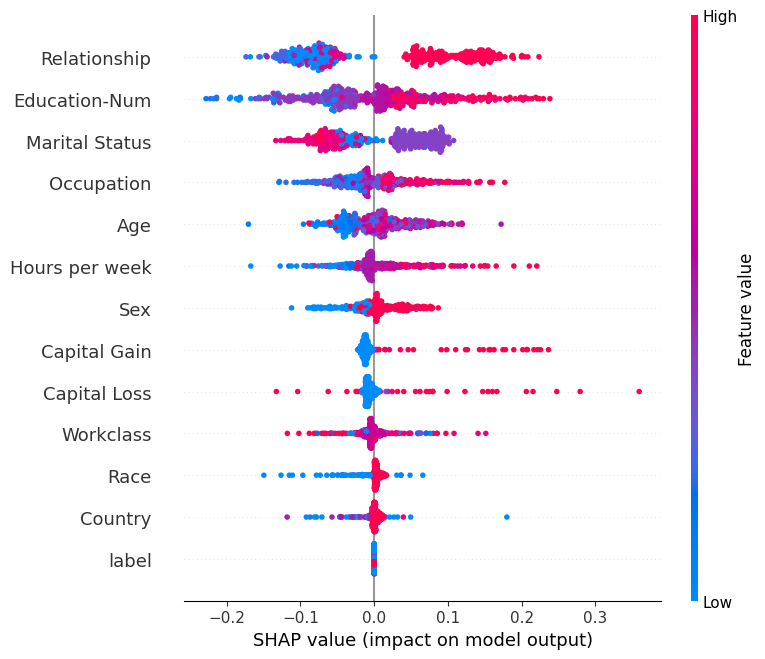

In [21]:
shap.summary_plot(shap_values)

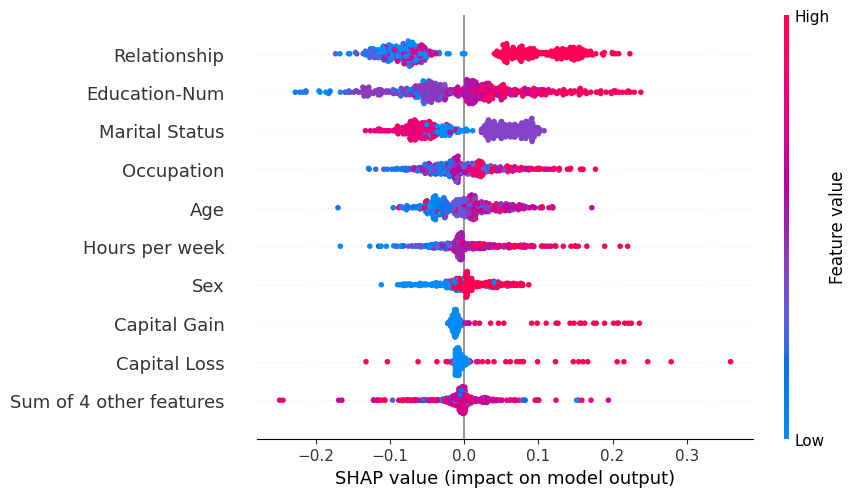

In [22]:
shap.plots.beeswarm(shap_values)

Sometimes it is helpful to transform the SHAP values before we plots them. Below we plot the absolute value and fix the color to be red.

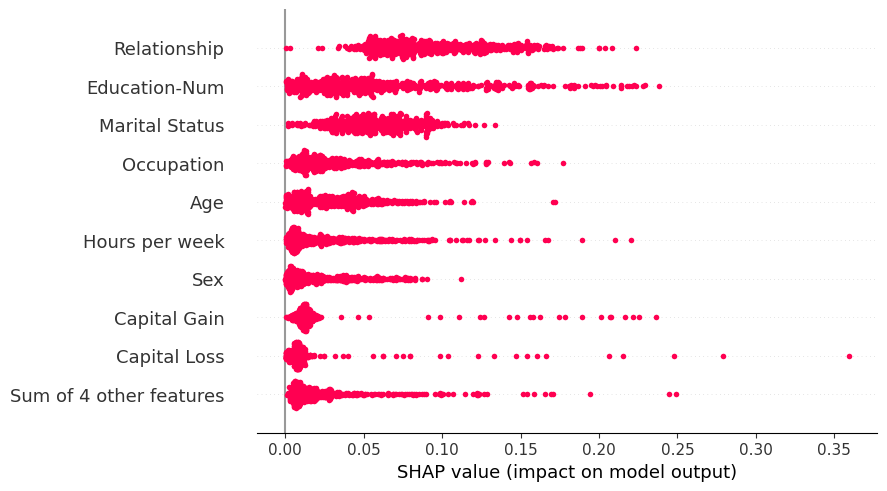

In [23]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

Passing a matrix of SHAP values to the bar plot function creates a **global feature importance** plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

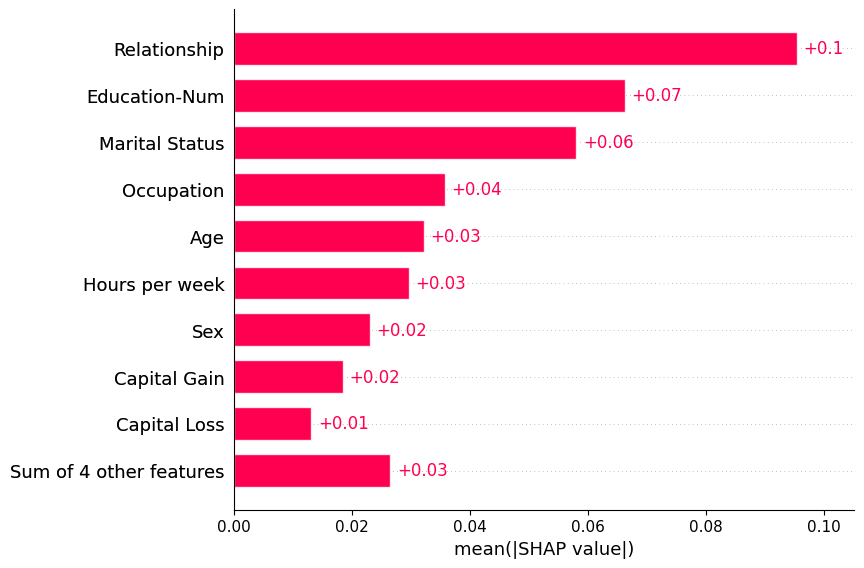

In [24]:
shap.plots.bar(shap_values)

Passing a row of SHAP values to the bar plot function creates a **local feature importance** plot, where the bars are the SHAP values for each feature. Note that the feature values are show in gray to the left of the feature names.

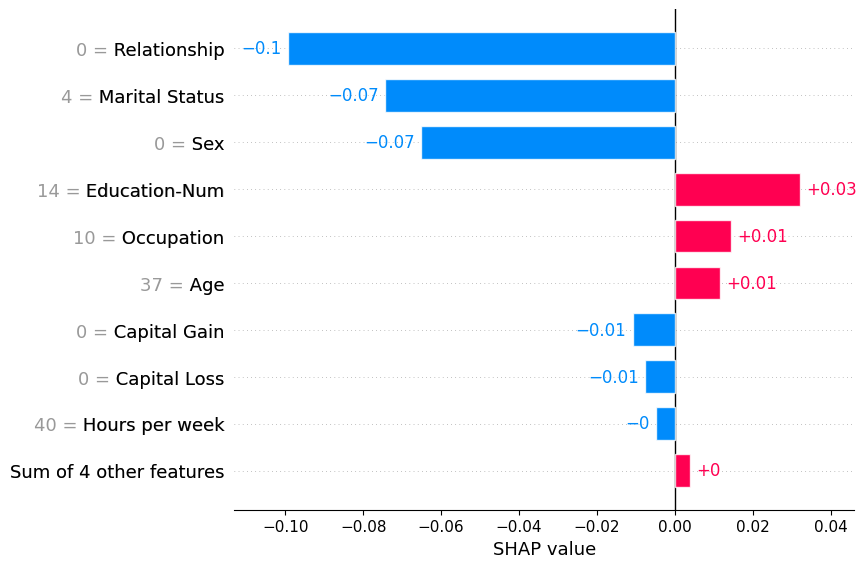

In [25]:
shap.plots.bar(shap_values[0])

Waterfall plots are designed to display explanations for individual predictions, so they expect a single row of an Explanation object as input. The bottom of a waterfall plot starts as the expected value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

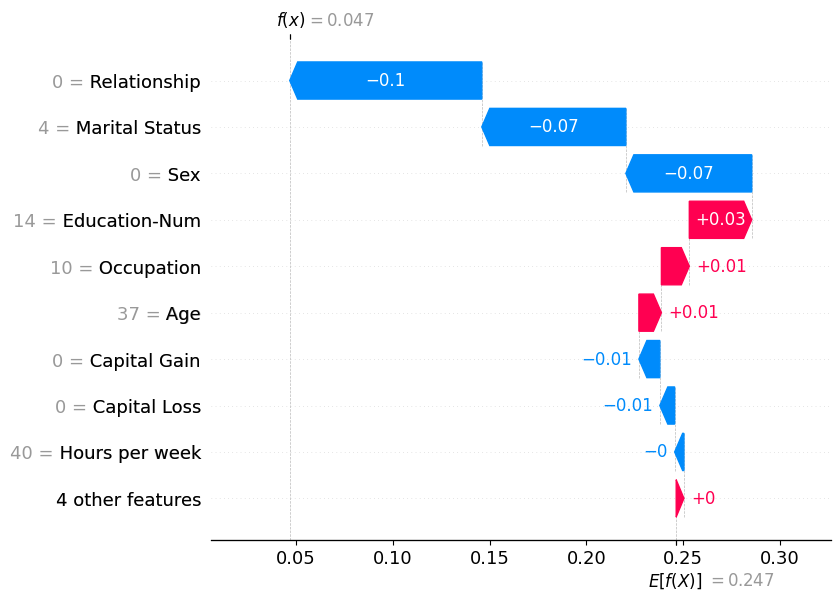

In [65]:
shap.plots.waterfall(shap_values[0])

another way to show local prediction is using **forceplot**.

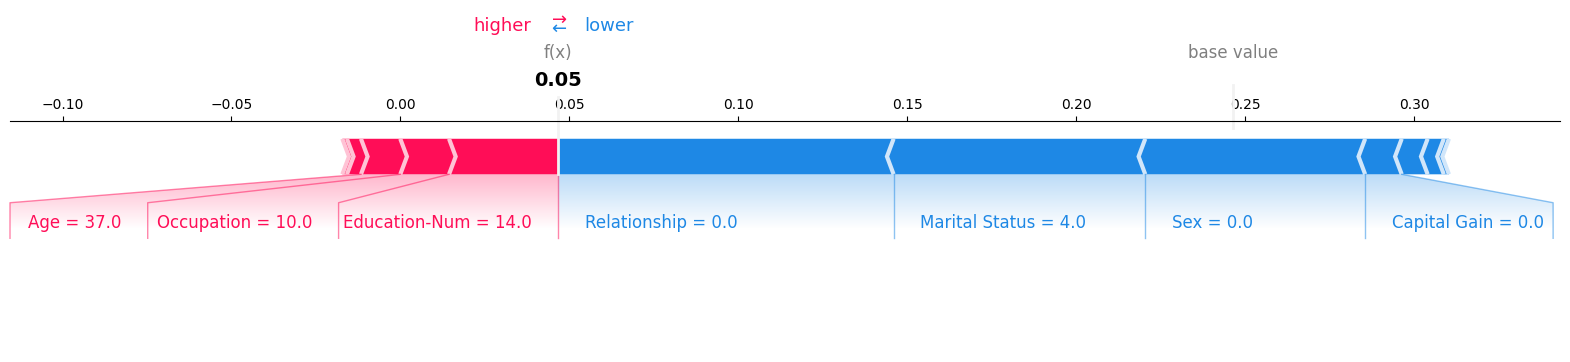

In [41]:
shap.force_plot(shap_values[0, :], X_display.iloc[0, :], matplotlib=True)

Force plot can also used to visualize many predictions in an interactive graph.

In [66]:
shap.initjs()
shap.force_plot(shap_values[:500, :], X_display.iloc[:500, :])

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

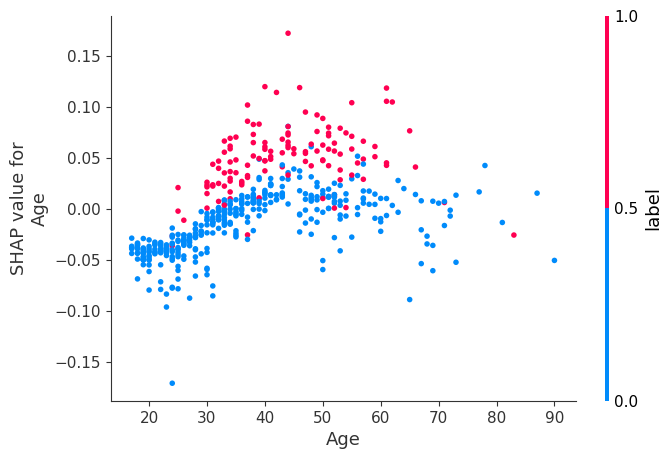

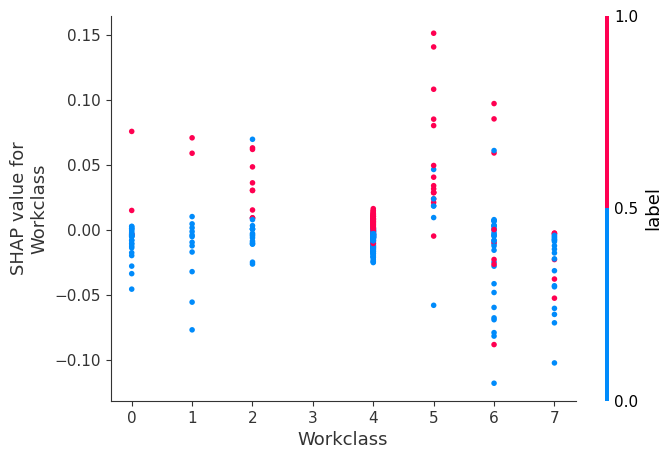

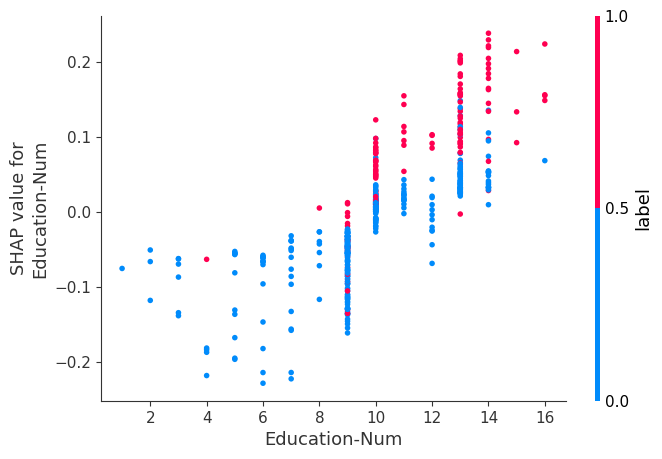

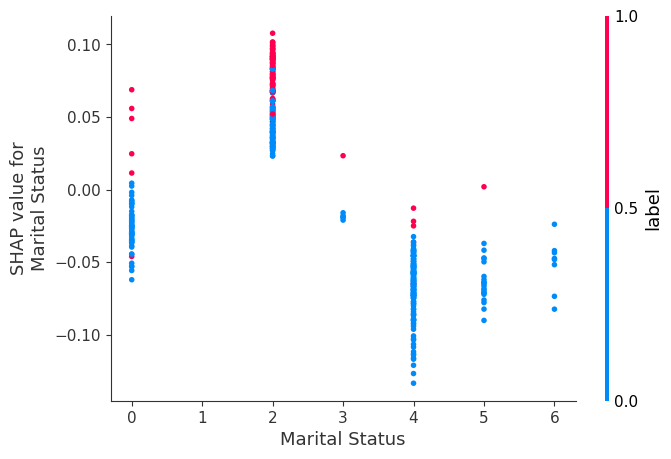

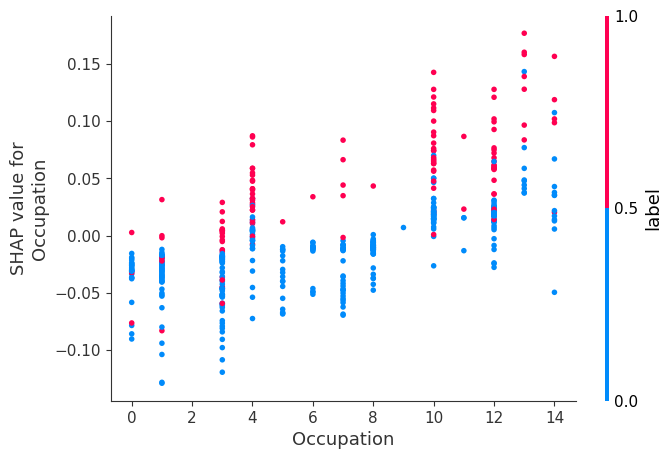

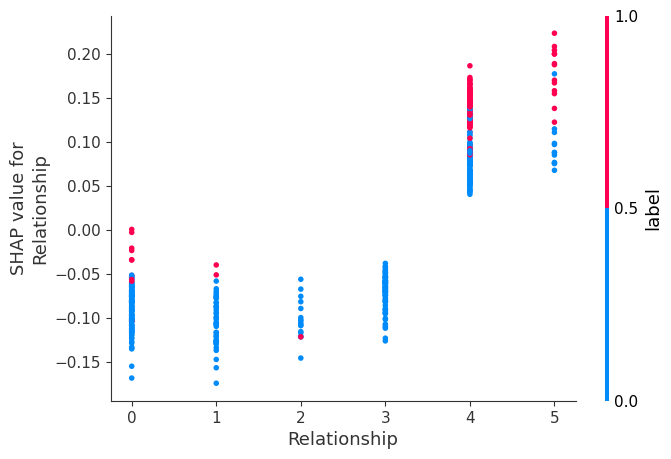

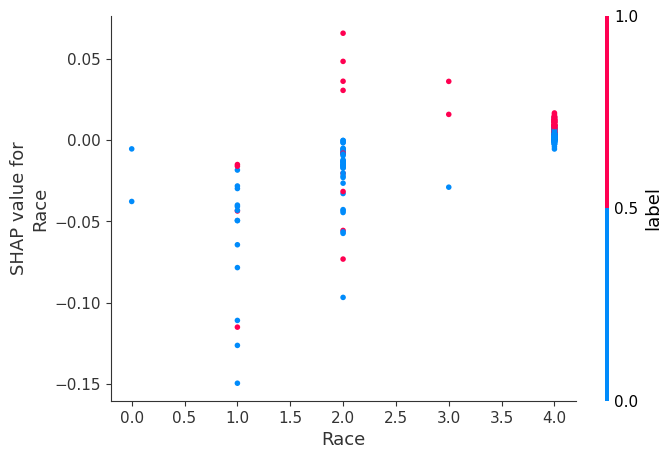

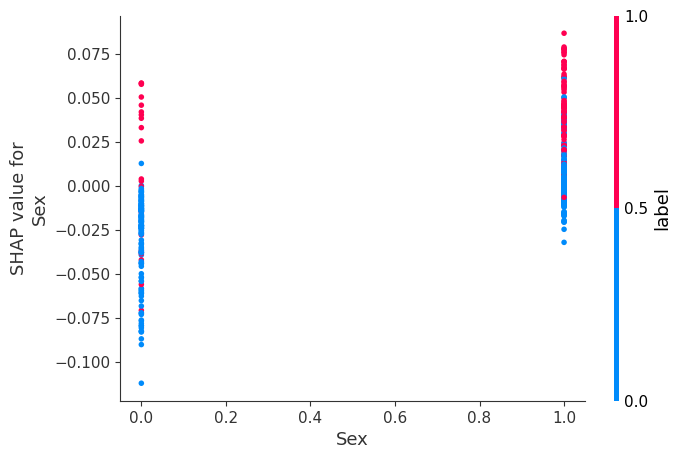

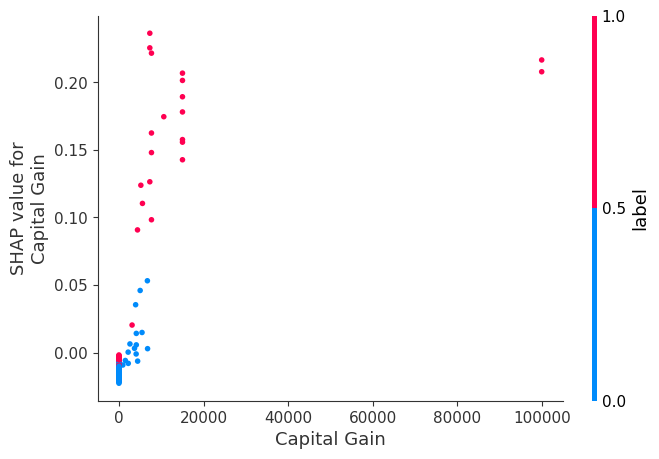

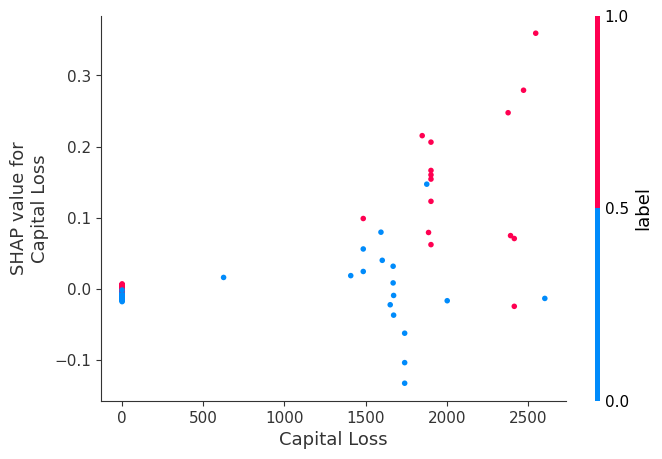

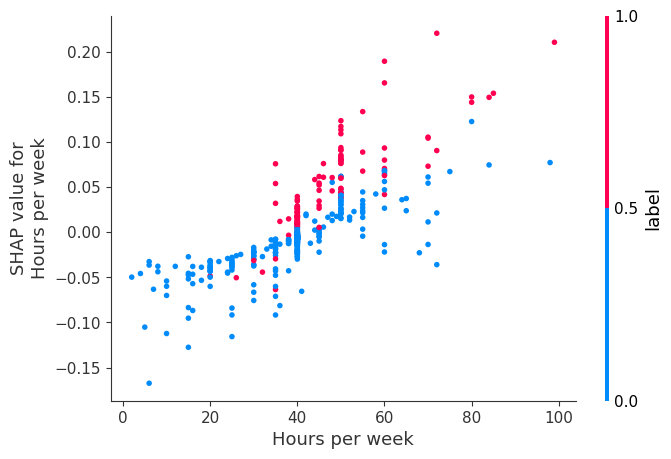

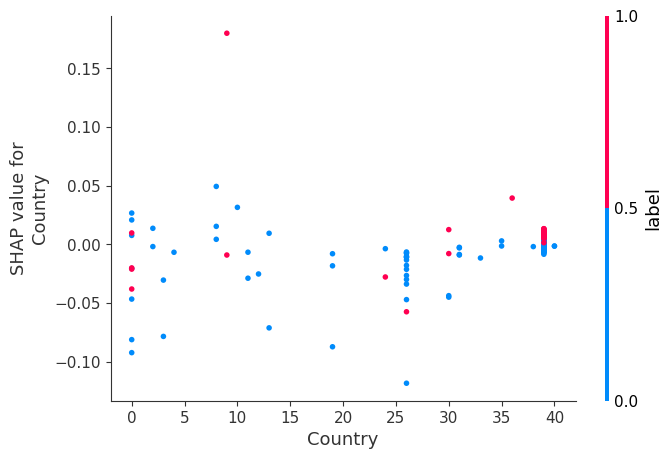

In [61]:
for name in train_data.columns.drop(label):  # Exclude the label column from feature names
    shap.dependence_plot(name, shap_values.values, train_data)

Passing a matrix of SHAP values to the heatmap plot function creates a plot with the instances on the x-axis, the model inputs on the y-axis, and the SHAP values encoded on a color scale.

The output of the model is shown above the heatmap matrix (centered around the explaination’s `.base_value`), and the global importance of each model input shown as a bar plot on the right hand side of the plot (by default this is the `shap.order.abs.mean` measure of overall importance).

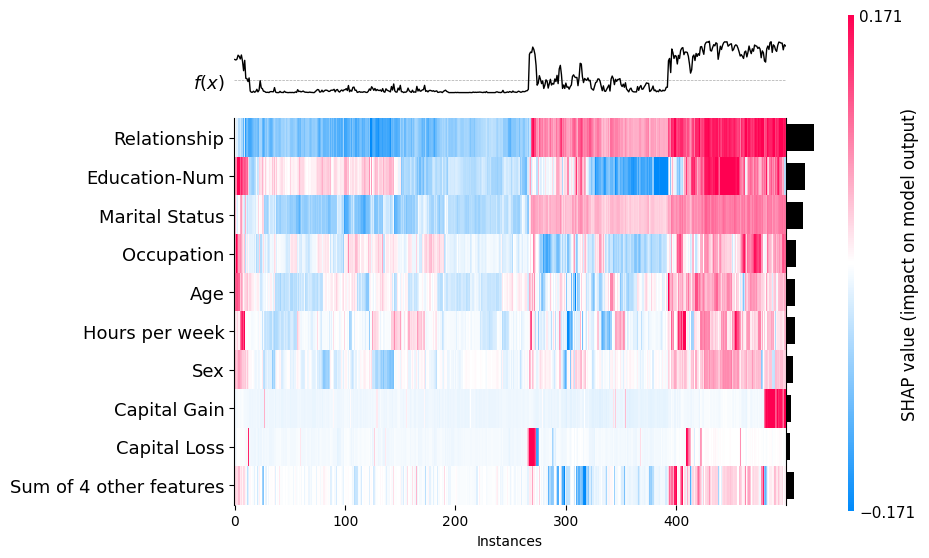

<Axes: xlabel='Instances'>

In [62]:
shap.plots.heatmap(shap_values)

Increasing the `max_display` parameter allows for more features to be shown:

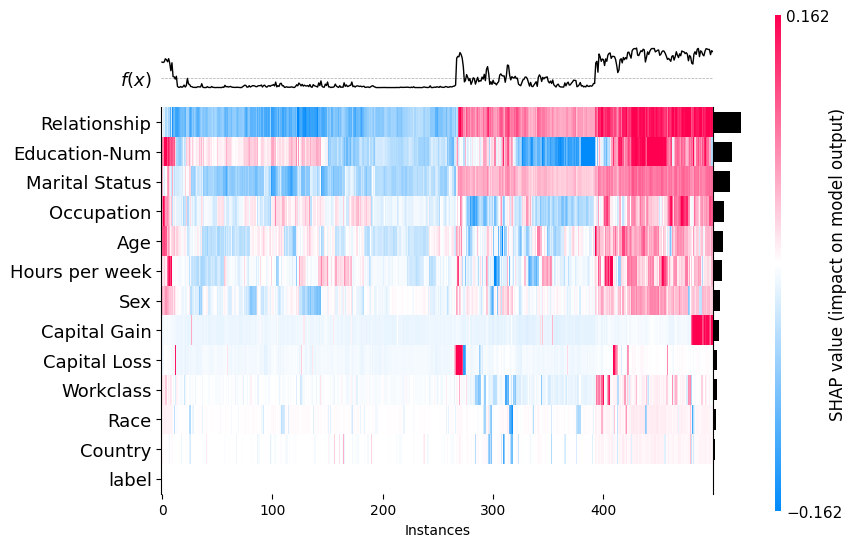

<Axes: xlabel='Instances'>

In [64]:
shap.plots.heatmap(shap_values, max_display=13)

## Conclusion
This demo illustrated Explainable AI with AutoGulon and the SHAP toolbox and provided a relatively standard procedure for implementing ensemble learning and explaining with SHAP value. ✌

**Notes**
1. Traditionally, the machine learning part would use [scikit-learn](https://scikit-learn.org/stable/index.html). Experienced users should understand the basic usage of sklearn, as it provides a more advanced, customizable, and broad machine learning framework. In fact, I used the sklearn method in the data loading part.
2. You may encounter errors when trying to run the exact same code in this demo depending on your system, Python version, and other factors. Don't be discouraged and try to debug them using the internet and AI.  
3. Usually you don't have to draw all this SHAP graph, I just list most of its functionality (with the description from its [official document](https://shap.readthedocs.io/en/stable/index.html)).  